# Source: https://scikit-learn.org/stable/auto_examples/decomposition/plot_image_denoising.html

In [1]:
import numpy as np
import sklearn
import scipy.linalg as LA
import matplotlib.pyplot as plt

## Import test image from scipy

In [2]:
from scipy.datasets import face

raccoon_face = face(gray=True).astype(np.float64)

# normalize
raccoon_face /= 255.0

# downsample for speed
raccoon_face = raccoon_face[::4, ::4] + raccoon_face[2::4, ::4] + raccoon_face[::4, 2::4] + raccoon_face[2::4, 2::4]
raccoon_face /= 4
height, width = raccoon_face.shape

# Distort the right half of the image
print('Distorting image')
distorted = raccoon_face.copy()
distorted[:, width // 2:] += .075 * np.random.randn(height, width // 2)

Distorting image


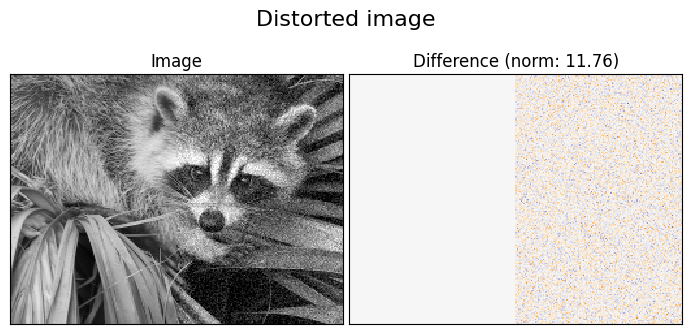

In [3]:
def show_with_diff(image, reference, title):
    plt.figure(figsize=(7, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference**2)))
    plt.imshow(
        difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation='nearest'
    )
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(.02, .02, .98, .79, .02, .2)

show_with_diff(distorted, raccoon_face, 'Distorted image')

## Extract reference patches

In [4]:
from time import time
from sklearn.feature_extraction.image import extract_patches_2d

# Extract patches from left half of the image
print('Extracting reference patches')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print(f'{data.shape[0]} patches extracted in %.2fs.' % (time() - t0))

Extracting reference patches
22692 patches extracted in 0.04s.


In [129]:
from sklearn.decomposition import SparseCoder

def kSVD(Y, T_0, k, num_iter, track_loss = True, debug = False):
    loss = []

    # Initialize dictionary
    D = np.random.randn(k, Y.shape[1])
    D = np.diag(1 / LA.norm(D, ord=2, axis=1)) @ D
    
    for iter in range(num_iter):
        # Sparse Coding Step
        if debug:
            print(f'Iteration {iter}, Sparse Coding Step...')
        t0 = time()

        
        X = SparseCoder(dictionary = D, transform_n_nonzero_coefs = T_0).transform(Y)
        if debug:
            print(f'Time: {time() - t0}')
        
        # Dictionary Update Step
        if debug:
            print(f'Iteration {iter}, Dictionary Update Step...')
        t0 = time()
        for i in range(k):
            x_i = X[:, i]
            filter = (x_i != 0)
            x_i_R = x_i[filter]
            if x_i_R.shape[0] == 0:
                # print('Warning: Dictionary atom unused? Skipping update...')
                continue
            
            E_k_R = Y[filter]
            for j in range(k):
                if j != i:
                    # print(X[filter, j][:, np.newaxis].shape)
                    # print(D[j][np.newaxis, :].shape)
                    E_k_R -= X[filter, j][:, np.newaxis] @ D[j][np.newaxis, :]

            # print(E_k_R.shape)
            U, S, Vh = LA.svd(E_k_R)

            X[filter, i] = U[:, 0] * S[0]
            D[i] = Vh[0]

        if debug:
            print(f'Time: {time() - t0}')
        
        loss.append(LA.norm(Y - X @ D, ord='fro'))

    return D, loss

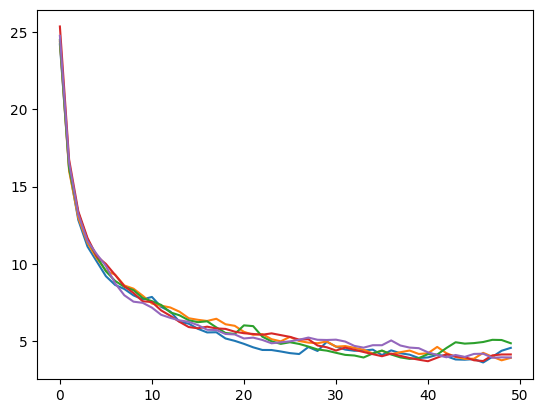

In [138]:
for i in range(5):
    D, loss = kSVD(data[:250], 5, 250, 50, debug=False)
    plt.plot(loss)
plt.show()